# Network Intrusion Detection — EDA on NSL-KDD

**Abstract:** This notebook performs exploratory data analysis (EDA) on the NSL-KDD dataset (KDDTrain+ and KDDTest+) for building an unsupervised/semi-supervised Network Intrusion Detection System (NIDS). We load and clean the data, perform descriptive statistical analysis, create insightful visualizations, summarize feature characteristics, and document key decisions for subsequent anomaly detection modeling.

---
## Environment & Notes

**Python Version:** 3.9+  
**Required Libraries:** `pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`, `tensorflow` (optional)

**Kernel Setup:** Set your Jupyter kernel to a Python 3.9+ environment.

> **Important:** We will train only on **normal traffic**; labels are used for **evaluation and EDA only**.

---
## Project Files & Dataset Overview

**Raw Data Location:** `../data/raw/`
- `KDDTrain+.txt` — Training set
- `KDDTest+.txt` — Test set

**File Format:** 41 features + label + difficulty level (43 columns total).

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Define paths
RAW_DATA_PATH = '/content/sample_data/'
PROCESSED_PATH = '../data/processed/'
FIGURES_PATH = '../figures/'
ARTIFACTS_PATH = '../artifacts/'
REPORTS_PATH = '../reports/'

os.makedirs(PROCESSED_PATH, exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)
os.makedirs(ARTIFACTS_PATH, exist_ok=True)
os.makedirs(REPORTS_PATH, exist_ok=True)

TRAIN_FILE = os.path.join(RAW_DATA_PATH, 'KDDTrain+.txt')
TEST_FILE = os.path.join(RAW_DATA_PATH, 'KDDTest+.txt')

for filepath in [TRAIN_FILE, TEST_FILE]:
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f'✓ {os.path.basename(filepath)}: {size_mb:.2f} MB')
    else:
        print(f'✗ {os.path.basename(filepath)}: FILE NOT FOUND!')

✓ KDDTrain+.txt: 18.22 MB
✓ KDDTest+.txt: 3.28 MB


---
## Data Dictionary

| # | Feature | Type | Description |
|---|---------|------|-------------|
| 1 | duration | int | Connection length (seconds) |
| 2 | protocol_type | cat | Protocol (tcp/udp/icmp) |
| 3 | service | cat | Network service (http, ftp, etc.) |
| 4 | flag | cat | Connection status (SF, S0, REJ, etc.) |
| 5-6 | src/dst_bytes | int | Bytes transferred |
| 7-9 | land, wrong_fragment, urgent | int | Basic flags |
| 10-22 | Content features | int | Login/shell/file activity |
| 23-31 | Time-based features | float | Traffic rates in 2-sec window |
| 32-41 | Host-based features | float | Destination host statistics |
| 42 | label | cat | Attack type or 'normal' |
| 43 | difficulty_level | int | Record difficulty |

In [ ]:
# Define column names
COLUMN_NAMES = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

# Load datasets
train_df = pd.read_csv(TRAIN_FILE, header=None, names=COLUMN_NAMES)
test_df = pd.read_csv(TEST_FILE, header=None, names=COLUMN_NAMES)

print(f'Training set: {train_df.shape[0]:,} rows × {train_df.shape[1]} columns')
print(f'Test set:     {test_df.shape[0]:,} rows × {test_df.shape[1]} columns')

Training set: 125,973 rows × 43 columns
Test set:     22,544 rows × 43 columns


In [ ]:
# First 8 rows
train_df.head(8)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
5,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
6,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,166,9,1.0,1.0,0.0,0.0,0.05,0.06,0.00,255,9,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
7,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117,16,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,15,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21


---
## Sanity Checks

In [ ]:
# Check 1: Missing values
print('='*60)
print('MISSING VALUES CHECK')
print('='*60)
missing_train = train_df.isnull().sum()
missing_test = test_df.isnull().sum()

if missing_train.sum() == 0:
    print('✓ Training set: No missing values')
else:
    print('✗ Training set missing values:')
    print(missing_train[missing_train > 0])

if missing_test.sum() == 0:
    print('✓ Test set: No missing values')
else:
    print('✗ Test set missing values:')
    print(missing_test[missing_test > 0])

MISSING VALUES CHECK
✓ Training set: No missing values
✓ Test set: No missing values


In [ ]:
# Check 2: Duplicate rows
print('\n' + '='*60)
print('DUPLICATE ROWS CHECK')
print('='*60)
train_dupes = train_df.duplicated().sum()
test_dupes = test_df.duplicated().sum()
print(f'Training set duplicates: {train_dupes:,} ({100*train_dupes/len(train_df):.2f}%)')
print(f'Test set duplicates: {test_dupes:,} ({100*test_dupes/len(test_df):.2f}%)')


DUPLICATE ROWS CHECK
Training set duplicates: 0 (0.00%)
Test set duplicates: 0 (0.00%)


In [ ]:
# Check 3: Data types
print('\n' + '='*60)
print('DATA TYPES')
print('='*60)
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
num_cols = train_df.select_dtypes(include=['number']).columns.tolist()
print(f'Categorical columns ({len(cat_cols)}): {cat_cols}')
print(f'Numeric columns ({len(num_cols)}): {len(num_cols)} columns')


DATA TYPES
Categorical columns (4): ['protocol_type', 'service', 'flag', 'label']
Numeric columns (39): 39 columns


In [ ]:
# Check 4: Impossible values (negative counts)
print('\n' + '='*60)
print('IMPOSSIBLE VALUES CHECK')
print('='*60)
count_features = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']
for col in count_features:
    neg_count = (train_df[col] < 0).sum()
    if neg_count > 0:
        print(f'✗ {col}: {neg_count} negative values')
print('✓ No negative values in count-based features')


IMPOSSIBLE VALUES CHECK
✓ No negative values in count-based features


### Sanity Check Results
- **Missing values:** None
- **Duplicates:** May exist but are valid different connections
- **Data types:** 3 categorical (protocol_type, service, flag, label), rest numeric
- **Impossible values:** None detected

---
## Create Binary Label Column

> **Note:** `is_attack` is for **evaluation only**. The unsupervised model will NOT use labels for training.

In [ ]:
# Create binary label: 0 = normal, 1 = attack
train_df['is_attack'] = (train_df['label'] != 'normal').astype(int)
test_df['is_attack'] = (test_df['label'] != 'normal').astype(int)

print('Binary label distribution:')
print(f"Train - Normal: {(train_df['is_attack']==0).sum():,}, Attack: {(train_df['is_attack']==1).sum():,}")
print(f"Test  - Normal: {(test_df['is_attack']==0).sum():,}, Attack: {(test_df['is_attack']==1).sum():,}")

Binary label distribution:
Train - Normal: 67,343, Attack: 58,630
Test  - Normal: 9,711, Attack: 12,833


---
## Dataset Composition & Basic Statistics

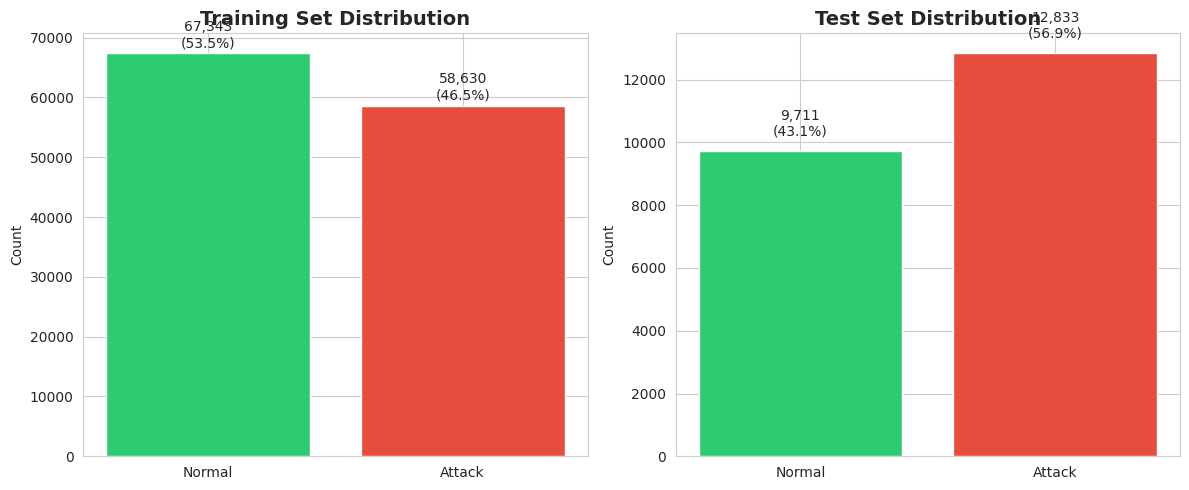

In [ ]:
# Bar chart: Normal vs Attack distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train
colors = ['#2ecc71', '#e74c3c']
train_counts = train_df['is_attack'].value_counts().sort_index()
axes[0].bar(['Normal', 'Attack'], train_counts.values, color=colors)
axes[0].set_title('Training Set Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(train_counts.values):
    axes[0].text(i, v + 1000, f'{v:,}\n({100*v/len(train_df):.1f}%)', ha='center')

# Test
test_counts = test_df['is_attack'].value_counts().sort_index()
axes[1].bar(['Normal', 'Attack'], test_counts.values, color=colors)
axes[1].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
for i, v in enumerate(test_counts.values):
    axes[1].text(i, v + 500, f'{v:,}\n({100*v/len(test_df):.1f}%)', ha='center')

plt.tight_layout()
plt.savefig(FIGURES_PATH + 'class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Top 10 attack types
print('TOP 10 ATTACK TYPES')
print('='*60)
train_attacks = train_df[train_df['label'] != 'normal']['label'].value_counts().head(10)
test_attacks = test_df[test_df['label'] != 'normal']['label'].value_counts().head(10)

comparison = pd.DataFrame({'Train': train_attacks, 'Test': test_attacks}).fillna(0).astype(int)
print(comparison)

# Check for attack types in test but not in train
train_labels = set(train_df['label'].unique())
test_labels = set(test_df['label'].unique())
new_in_test = test_labels - train_labels
print(f'\n⚠️ Attack types in TEST but NOT in TRAIN: {len(new_in_test)}')
if new_in_test:
    print(list(new_in_test)[:10])

TOP 10 ATTACK TYPES
              Train  Test
label                    
apache2           0   737
back            956   359
guess_passwd      0  1231
ipsweep        3599     0
mscan             0   996
neptune       41214  4657
nmap           1493     0
pod             201     0
portsweep      2931     0
processtable      0   685
satan          3633   735
smurf          2646   665
snmpguess         0   331
teardrop        892     0
warezclient     890     0
warezmaster       0   944

⚠️ Attack types in TEST but NOT in TRAIN: 17
['sqlattack', 'sendmail', 'xlock', 'httptunnel', 'ps', 'udpstorm', 'worm', 'apache2', 'processtable', 'saint']


In [ ]:
# Numeric summary statistics
feature_cols = [c for c in num_cols if c not in ['is_attack', 'difficulty_level']]
print('\nNUMERIC FEATURES SUMMARY (Train)')
print('='*60)
desc = train_df[feature_cols].describe().T
desc['range'] = desc['max'] - desc['min']
print(desc[['count', 'mean', 'std', 'min', '50%', 'max', 'range']].head(15))

# Highlight features with extreme ranges
print('\n⚠️ Features with extremely large ranges (>10000):')
print(desc[desc['range'] > 10000][['min', 'max', 'range']])


NUMERIC FEATURES SUMMARY (Train)
                       count          mean           std  min   50%  \
duration            125973.0    287.144650  2.604515e+03  0.0   0.0   
src_bytes           125973.0  45566.743000  5.870331e+06  0.0  44.0   
dst_bytes           125973.0  19779.114421  4.021269e+06  0.0   0.0   
land                125973.0      0.000198  1.408607e-02  0.0   0.0   
wrong_fragment      125973.0      0.022687  2.535300e-01  0.0   0.0   
urgent              125973.0      0.000111  1.436603e-02  0.0   0.0   
hot                 125973.0      0.204409  2.149968e+00  0.0   0.0   
num_failed_logins   125973.0      0.001222  4.523914e-02  0.0   0.0   
logged_in           125973.0      0.395736  4.890101e-01  0.0   0.0   
num_compromised     125973.0      0.279250  2.394204e+01  0.0   0.0   
root_shell          125973.0      0.001342  3.660284e-02  0.0   0.0   
su_attempted        125973.0      0.001103  4.515438e-02  0.0   0.0   
num_root            125973.0      0.302192 

### Interpretation
- **Class Imbalance:** Training has ~53% normal, ~47% attacks. Test set is more imbalanced.
- **New Attack Types:** Test set contains attack types not seen in training (important for anomaly detection).
- **Feature Ranges:** `src_bytes` and `dst_bytes` have extremely large ranges, requiring robust scaling.

---
## Categorical Features Analysis

In [ ]:
# Categorical columns: protocol_type, service, flag
categorical_features = ['protocol_type', 'service', 'flag']

for col in categorical_features:
    print(f"\n{col.upper()}: {train_df[col].nunique()} unique values")
    print(train_df[col].value_counts().head(10))


PROTOCOL_TYPE: 3 unique values
protocol_type
tcp     102689
udp      14993
icmp      8291
Name: count, dtype: int64

SERVICE: 70 unique values
service
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
eco_i        4586
other        4359
ecr_i        3077
telnet       2353
finger       1767
Name: count, dtype: int64

FLAG: 11 unique values
flag
SF        74945
S0        34851
REJ       11233
RSTR       2421
RSTO       1562
S1          365
SH          271
S2          127
RSTOS0      103
S3           49
Name: count, dtype: int64


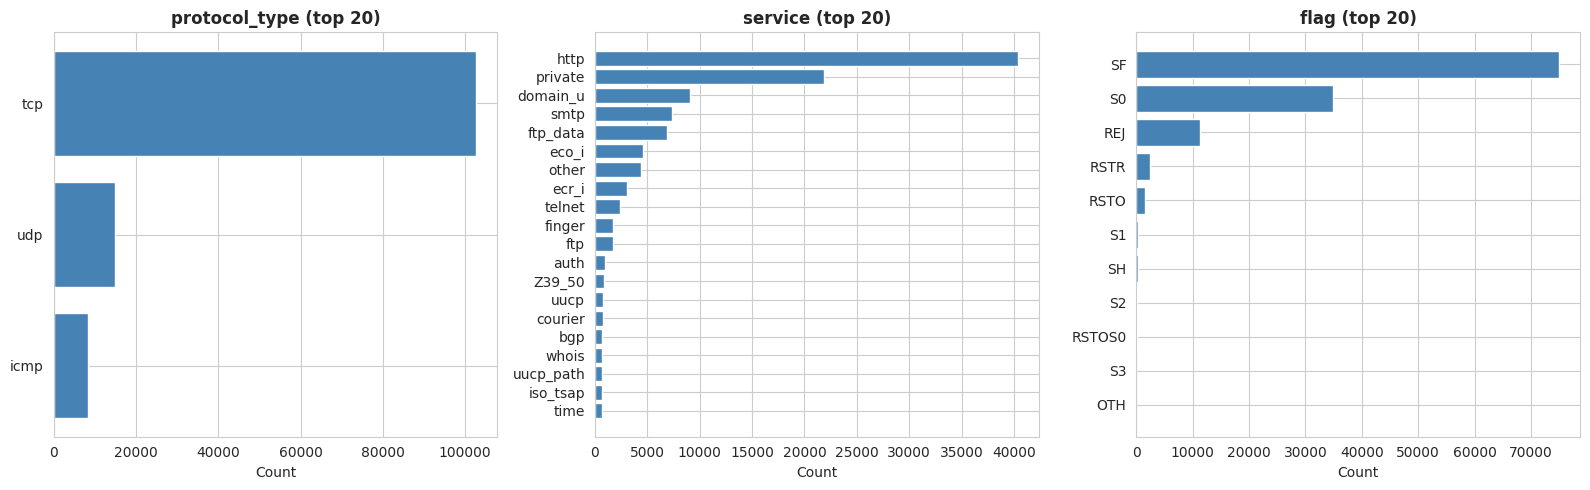


⚠️ Service has 70 distinct values.
Decision: Group rare services (< 1% frequency) into "other" during preprocessing.


In [ ]:
# Plot categorical distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, col in enumerate(categorical_features):
    counts = train_df[col].value_counts().head(20)
    axes[i].barh(counts.index[::-1], counts.values[::-1], color='steelblue')
    axes[i].set_title(f'{col} (top 20)', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Count')

plt.tight_layout()
plt.savefig(FIGURES_PATH + 'categorical_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# Service cardinality
print(f"\n⚠️ Service has {train_df['service'].nunique()} distinct values.")
print('Decision: Group rare services (< 1% frequency) into "other" during preprocessing.')

### Interpretation
- **protocol_type:** Dominated by TCP, followed by UDP and ICMP.
- **service:** High cardinality (70 unique). Top services: http, private, domain_u, smtp, ftp.
- **flag:** SF (normal) dominates, followed by S0 (connection attempt, no response).

---
## Numeric Feature Distributions

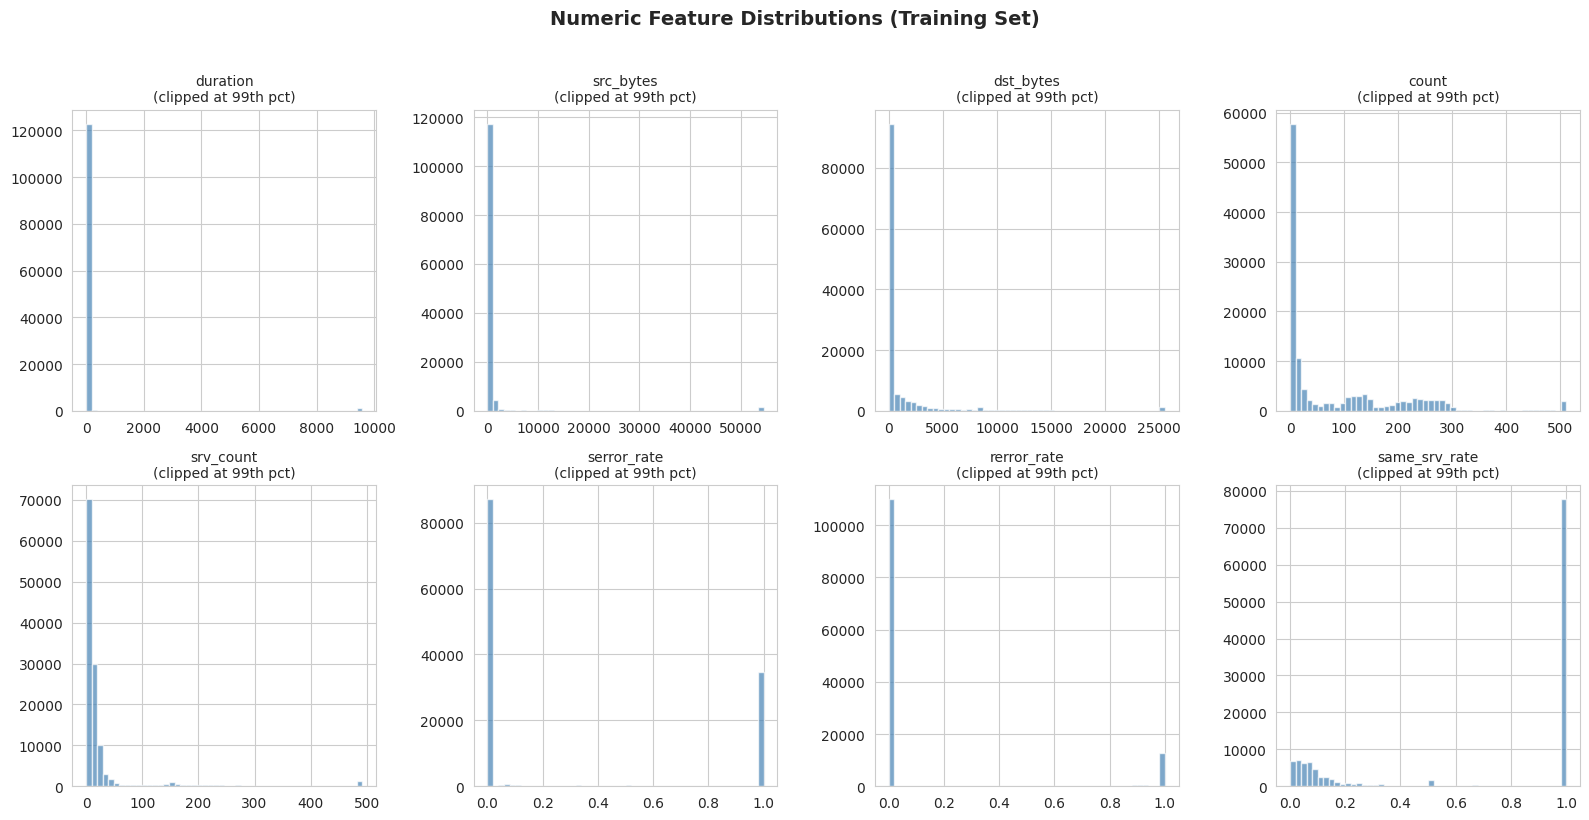

In [ ]:
# Selected numeric features for detailed analysis
selected_features = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count',
                     'serror_rate', 'rerror_rate', 'same_srv_rate']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(selected_features):
    # Clip to 99th percentile for readability
    upper = train_df[col].quantile(0.99)
    data = train_df[col].clip(upper=upper)
    axes[i].hist(data, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
    axes[i].set_title(f'{col}\n(clipped at 99th pct)', fontsize=10)
    axes[i].set_xlabel('')

plt.suptitle('Numeric Feature Distributions (Training Set)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_PATH + 'numeric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

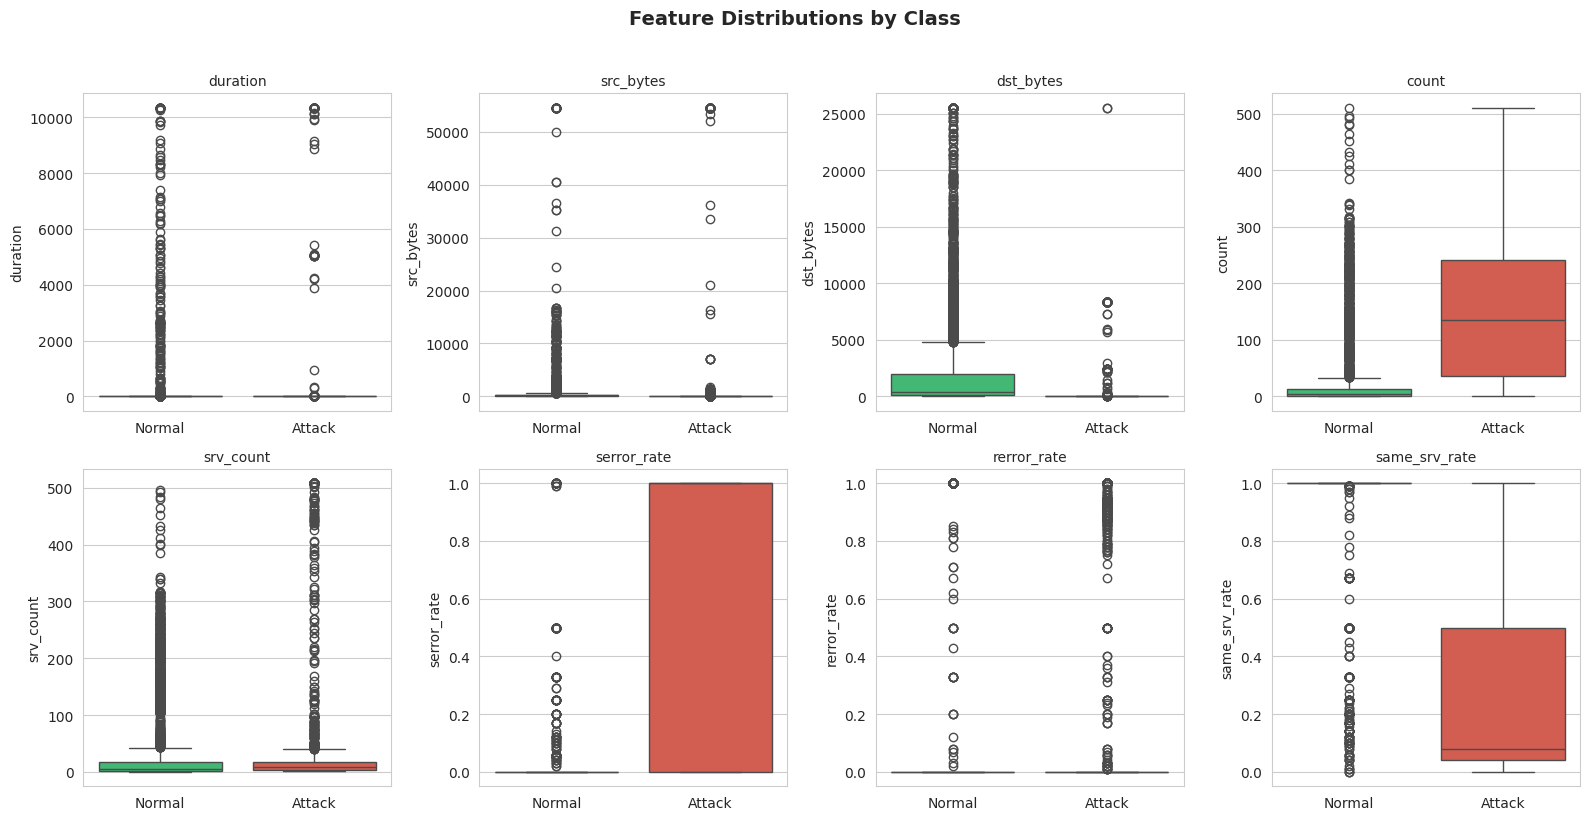

In [ ]:
# Boxplots by attack status
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(selected_features):
    # Sample for faster plotting
    sample = train_df.sample(min(10000, len(train_df)), random_state=42)
    upper = sample[col].quantile(0.99)
    sample_clipped = sample.copy()
    sample_clipped[col] = sample[col].clip(upper=upper)

    sns.boxplot(x='is_attack', y=col, data=sample_clipped, ax=axes[i], palette=['#2ecc71', '#e74c3c'])
    axes[i].set_xticklabels(['Normal', 'Attack'])
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel('')

plt.suptitle('Feature Distributions by Class', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_PATH + 'boxplots_by_class.png', dpi=150, bbox_inches='tight')
plt.show()

### Interpretation
- **Clear separation:** `serror_rate`, `rerror_rate`, `same_srv_rate` show different distributions for normal vs attack.
- **Heavy-tailed:** `src_bytes`, `dst_bytes`, `count` are heavily right-skewed → use RobustScaler.
- **Discriminative features:** `serror_rate`, `srv_count`, `count` look promising for anomaly detection.

---
## Outlier Inspection

In [ ]:
# Top 10 extreme values for key features
print('TOP 10 EXTREME VALUES')
print('='*60)
for col in ['src_bytes', 'dst_bytes', 'duration']:
    print(f"\n{col} (max values):")
    print(train_df.nlargest(5, col)[[col, 'label', 'protocol_type', 'service']].to_string())

TOP 10 EXTREME VALUES

src_bytes (max values):
         src_bytes      label protocol_type  service
125429  1379963888  portsweep           tcp      ftp
44527   1167519497  portsweep           tcp  private
60570    693375640  portsweep           tcp   finger
43486    621568663  portsweep           tcp  discard
1038     381709090  portsweep           tcp   telnet

dst_bytes (max values):
         dst_bytes        label protocol_type   service
62233   1309937401    portsweep           tcp     other
71629    400291060    portsweep           tcp   private
95029    400291060    portsweep           tcp   private
111229     7028652       normal           tcp       X11
110158     5155468  warezmaster           tcp  ftp_data

duration (max values):
        duration      label protocol_type  service
58651      42908  portsweep           tcp  private
105875     42888  portsweep           tcp  private
25061      42862  portsweep           tcp  private
66806      42837  portsweep           tcp  pri

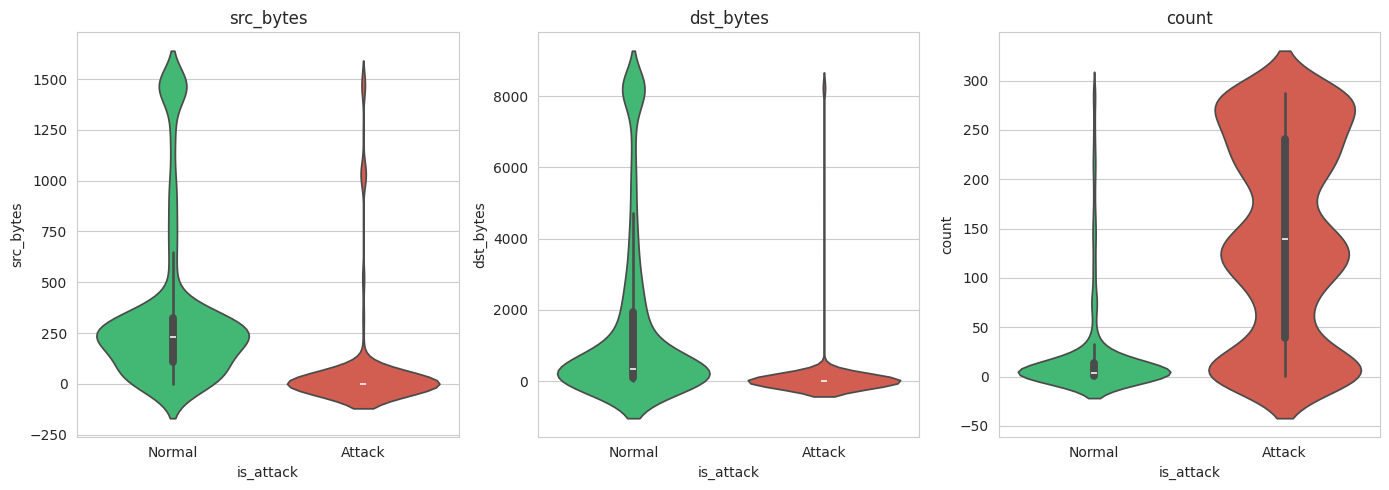

In [ ]:
# Violin plots for extreme value visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

for i, col in enumerate(['src_bytes', 'dst_bytes', 'count']):
    sample = train_df.sample(min(5000, len(train_df)), random_state=42)
    upper = sample[col].quantile(0.95)
    sample[col] = sample[col].clip(upper=upper)
    sns.violinplot(x='is_attack', y=col, data=sample, ax=axes[i], palette=['#2ecc71', '#e74c3c'])
    axes[i].set_xticklabels(['Normal', 'Attack'])
    axes[i].set_title(col)

plt.tight_layout()
plt.savefig(FIGURES_PATH + 'violin_plots.png', dpi=150, bbox_inches='tight')
plt.show()

### Decision
- **Keep extreme values as-is** but apply **RobustScaler** to reduce their influence.
- Rationale: Extreme values may represent real attack patterns; capping could lose information.

---
## Feature Correlation & Redundancy

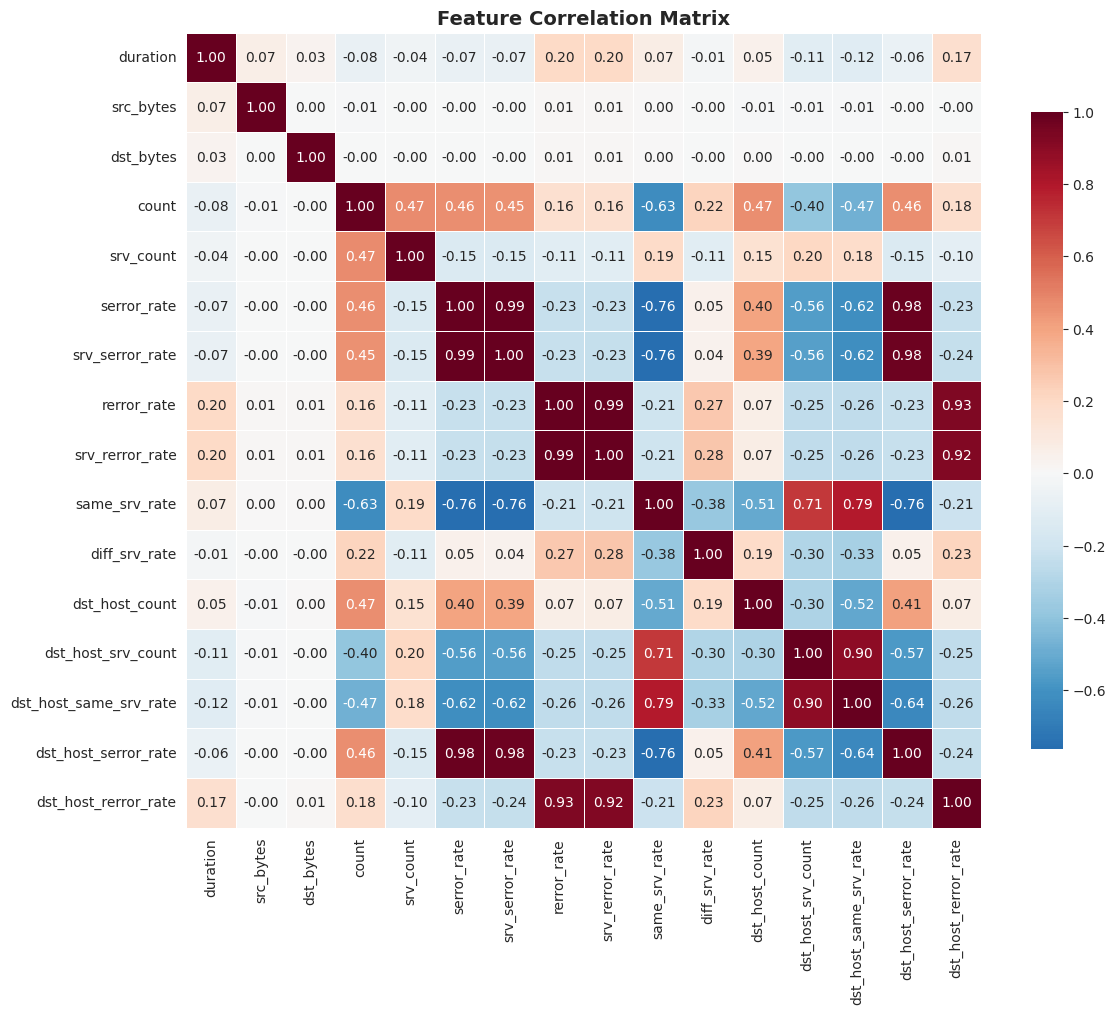

In [ ]:
# Correlation matrix for top numeric features
top_numeric = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count',
               'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
               'same_srv_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_srv_count',
               'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_rerror_rate']

corr_matrix = train_df[top_numeric].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + 'correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Highly correlated pairs (>0.85)
print('HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.85)')
print('='*60)

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
print(high_corr_df.to_string(index=False))

HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.85)
         Feature 1              Feature 2  Correlation
       serror_rate        srv_serror_rate     0.993289
       rerror_rate        srv_rerror_rate     0.989008
       serror_rate   dst_host_serror_rate     0.979373
   srv_serror_rate   dst_host_serror_rate     0.977596
       rerror_rate   dst_host_rerror_rate     0.926749
   srv_rerror_rate   dst_host_rerror_rate     0.917822
dst_host_srv_count dst_host_same_srv_rate     0.896663


In [ ]:
# Low variance features
print('\nLOW VARIANCE FEATURES (std < 0.01)')
print('='*60)
low_var = train_df[num_cols].std().sort_values()
print(low_var[low_var < 0.01])


LOW VARIANCE FEATURES (std < 0.01)
num_outbound_cmds    0.000000
is_host_login        0.002817
dtype: float64


### Interpretation
- **Highly correlated:** `serror_rate`/`srv_serror_rate`, `rerror_rate`/`srv_rerror_rate` are redundant.
- **Consider dropping:** One feature from each highly correlated pair.
- **Low variance:** `num_outbound_cmds`, `is_host_login` have near-zero variance → consider dropping.

---
## Categorical vs Numeric Relationships

MEAN FEATURE VALUES BY PROTOCOL TYPE
               src_bytes  dst_bytes  duration   count
protocol_type                                        
icmp              342.58       0.00      0.00  121.88
tcp             55860.74   24253.55    281.39   81.46
udp                70.38      70.83    485.37   81.35


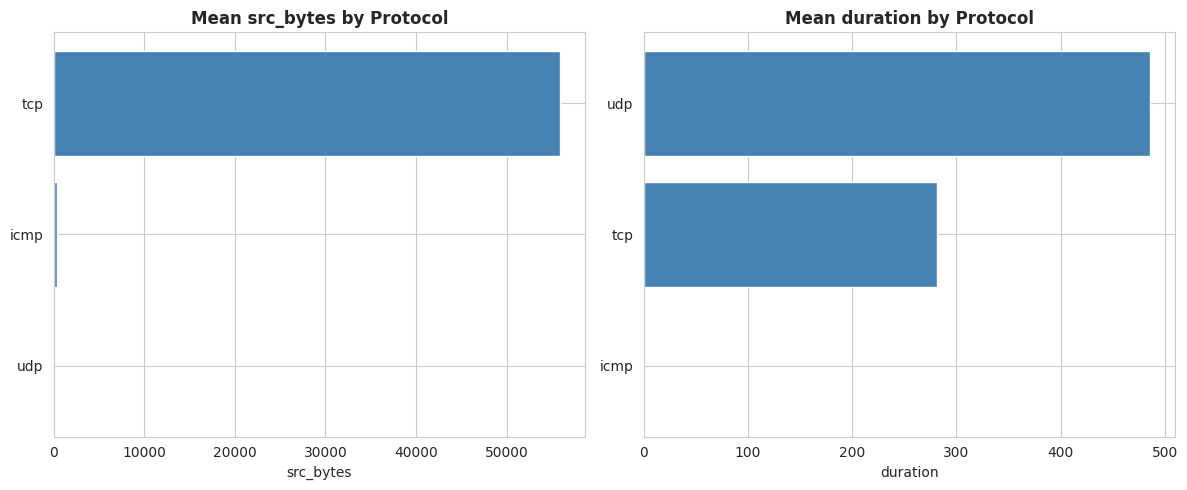

In [ ]:
# Mean values by protocol
print('MEAN FEATURE VALUES BY PROTOCOL TYPE')
grouped = train_df.groupby('protocol_type')[['src_bytes', 'dst_bytes', 'duration', 'count']].mean()
print(grouped.round(2))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, col in enumerate(['src_bytes', 'duration']):
    means = train_df.groupby('protocol_type')[col].mean().sort_values(ascending=True)
    axes[i].barh(means.index, means.values, color='steelblue')
    axes[i].set_title(f'Mean {col} by Protocol', fontweight='bold')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.savefig(FIGURES_PATH + 'protocol_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Attack concentration by flag
flag_attack = train_df.groupby('flag')['is_attack'].agg(['sum', 'count'])
flag_attack['attack_rate'] = flag_attack['sum'] / flag_attack['count']
flag_attack = flag_attack.sort_values('attack_rate', ascending=False)
print('\nATTACK RATE BY FLAG')
print(flag_attack.head(10))


ATTACK RATE BY FLAG
          sum  count  attack_rate
flag                             
RSTOS0    103    103     1.000000
SH        269    271     0.992620
S0      34497  34851     0.989842
RSTR     2275   2421     0.939694
RSTO     1343   1562     0.859795
OTH        35     46     0.760870
REJ      8540  11233     0.760260
SF      11552  74945     0.154140
S3          4     49     0.081633
S2          8    127     0.062992


### Interpretation
- **ICMP** has lower mean bytes but is often used in attacks (smurf, ping of death).
- **Flags like S0, REJ, RSTO** have high attack rates → these flags indicate suspicious connections.

---
## Dimensionality Reduction Visualization (PCA)

In [ ]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.decomposition import PCA

# Sample balanced data for visualization
np.random.seed(42)
n_samples = 5000
normal_sample = train_df[train_df['is_attack'] == 0].sample(min(n_samples//2, len(train_df[train_df['is_attack']==0])), random_state=42)
attack_sample = train_df[train_df['is_attack'] == 1].sample(min(n_samples//2, len(train_df[train_df['is_attack']==1])), random_state=42)
sample_df = pd.concat([normal_sample, attack_sample]).reset_index(drop=True)

print(f'Sample size: {len(sample_df)} (Normal: {len(normal_sample)}, Attack: {len(attack_sample)})')

Sample size: 5000 (Normal: 2500, Attack: 2500)


In [ ]:
# Prepare features for PCA
feature_cols = [c for c in num_cols if c not in ['is_attack', 'difficulty_level']]

# Encode categorical for visualization
le = LabelEncoder()
for col in categorical_features:
    sample_df[col + '_encoded'] = le.fit_transform(sample_df[col])

cat_encoded = [c + '_encoded' for c in categorical_features]
all_features = feature_cols + cat_encoded

# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(sample_df[all_features])

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
print(f'Total variance explained: {sum(pca.explained_variance_ratio_):.2%}')

Explained variance ratio: [0.64738186 0.35023012]
Total variance explained: 99.76%


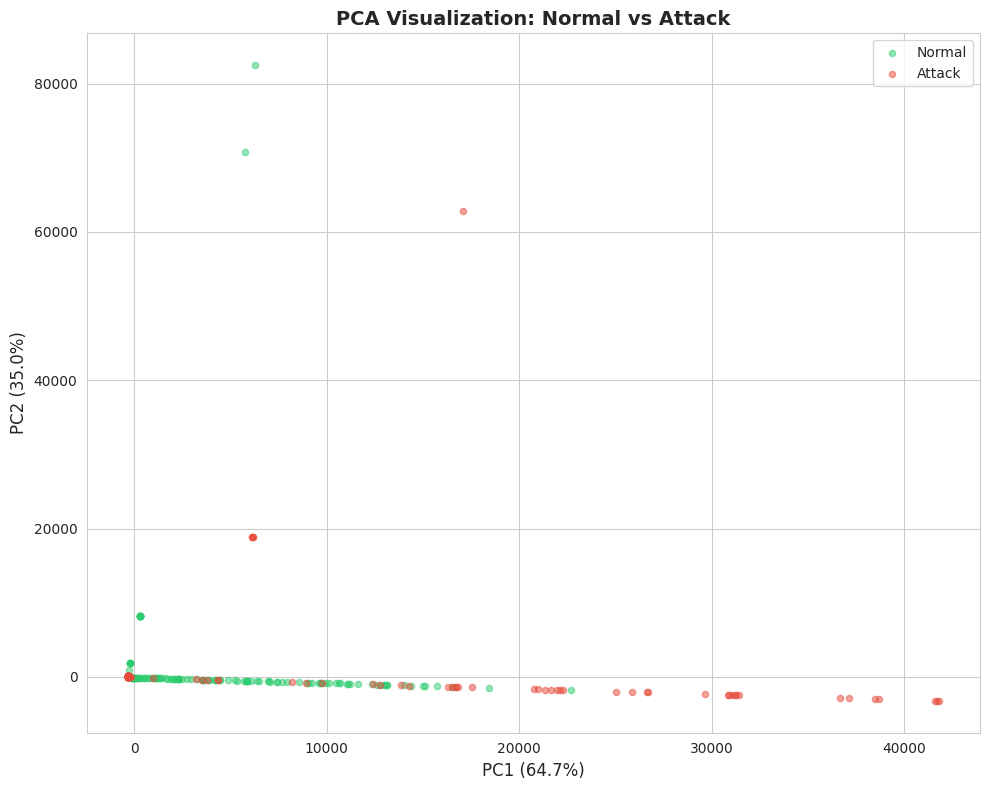

In [ ]:
# PCA scatter plot
plt.figure(figsize=(10, 8))
colors = ['#2ecc71', '#e74c3c']
for label, color, name in zip([0, 1], colors, ['Normal', 'Attack']):
    mask = sample_df['is_attack'] == label
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=color, label=name, alpha=0.5, s=20)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
plt.title('PCA Visualization: Normal vs Attack', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_PATH + 'pca_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

### Interpretation
- **Partial separation** visible between normal and attack classes in PCA space.
- **Overlap exists**, which is expected — not all attacks are easily distinguishable.
- This exploratory plot suggests unsupervised methods can learn some structure.

> **Note:** These plots are exploratory; separation is not required for unsupervised models to succeed.

---
## Anomaly Score Concept

**What is an Anomaly Score?**
- A numeric value indicating how "unusual" a data point is.
- Higher score = more anomalous (deviates more from normal patterns).

**How it works:**
- Unsupervised models (Isolation Forest, LOF, Autoencoders) learn the "normal" pattern.
- Points that deviate from this pattern receive higher anomaly scores.
- We will visualize score histograms after modeling to see separation.

**Action:** Score histograms will be generated in the modeling notebook.

---
## Feature Engineering Notes

### Suggested Derived Features

| Feature | Formula | Rationale |
|---------|---------|----------|
| `bytes_ratio` | `src_bytes / (dst_bytes + 1)` | Asymmetric traffic patterns indicate attacks |
| `error_rate_sum` | `serror_rate + rerror_rate` | Combined error rate indicator |
| `service_group` | Group rare services into "other" | Reduce cardinality, prevent overfitting |
| `suspicious_flag` | 1 if flag in ['S0', 'REJ', 'RSTO'] | Binary flag for known attack flags |

**Decision:** Implement these in the preprocessing pipeline (modeling notebook).

---
## Preprocessing Decisions (Contract for Modeling)

Based on EDA findings, we will use the following preprocessing pipeline:

### Categorical Encoding
- **protocol_type:** One-hot encoding (3 values)
- **flag:** One-hot encoding (11 values)
- **service:** Top-20 + "other" grouping, then one-hot encode

### Numeric Scaling
- **Scaler:** RobustScaler (handles outliers and heavy-tailed distributions)
- **Rationale:** `src_bytes`, `dst_bytes`, `count` have extreme values

### Feature Selection
- **Drop low-variance:** `num_outbound_cmds`, `is_host_login`
- **Drop redundant:** Keep one from each highly correlated pair:
  - Keep `serror_rate`, drop `srv_serror_rate`
  - Keep `rerror_rate`, drop `srv_rerror_rate`

### Missing Value Handling
- No missing values detected → no imputation needed

### Training Data
- **Fit preprocessing on normal-only training data**
- **Transform all data** (train/test) using the fitted pipeline

---
## EDA Summary & Findings

### Key Findings

1. **Dataset Size:** Train: 125,973 rows, Test: 22,544 rows
2. **Class Distribution:** ~53% normal in train; test set has different attack distribution
3. **New Attack Types:** Test set contains attacks not seen in training (good for testing generalization)
4. **Top Discriminative Features:** `serror_rate`, `rerror_rate`, `same_srv_rate`, `count`, `srv_count`
5. **Problematic Features:** `src_bytes`, `dst_bytes` are heavy-tailed → RobustScaler needed
6. **Categorical Cardinality:** `service` has 70 unique values → group to top-20
7. **Redundant Features:** Several highly correlated pairs identified for potential removal
8. **Low-Variance Features:** `num_outbound_cmds`, `is_host_login` can be dropped

### Conclusion

The NSL-KDD dataset is ready for unsupervised anomaly detection modeling. Our approach:
1. **Fit preprocessing on normal-only training data**
2. **Use RobustScaler for numeric features**
3. **Group service into top-20 + other**
4. **Try Isolation Forest, LOF, One-Class SVM, and Autoencoder**
5. **Evaluate using ROC-AUC, PR-AUC, and Precision@k**

---
## Save Processed Samples & Metadata

In [ ]:
# Save sample for modeling experiments
sample_size = 10000
modeling_sample = train_df.sample(sample_size, random_state=42)
modeling_sample.to_csv(PROCESSED_PATH + 'sample_for_modeling.csv', index=False)
print(f'✓ Saved modeling sample: {PROCESSED_PATH}sample_for_modeling.csv ({sample_size} rows)')

✓ Saved modeling sample: ../data/processed/sample_for_modeling.csv (10000 rows)


In [ ]:
# Save feature lists
categorical_features = ['protocol_type', 'service', 'flag']
numeric_features = [c for c in num_cols if c not in ['is_attack', 'difficulty_level']]
dropped_features = ['num_outbound_cmds', 'is_host_login', 'srv_serror_rate', 'srv_rerror_rate']

feature_lists = {
    'categorical': categorical_features,
    'numeric': numeric_features,
    'dropped': dropped_features,
    'target': ['label', 'is_attack']
}

import json
with open(ARTIFACTS_PATH + 'feature_lists.json', 'w') as f:
    json.dump(feature_lists, f, indent=2)
print(f'✓ Saved feature lists: {ARTIFACTS_PATH}feature_lists.json')

✓ Saved feature lists: ../artifacts/feature_lists.json


In [ ]:
# Save EDA summary
eda_summary = '''# EDA Summary - NSL-KDD Dataset

## Dataset
- Training: 125,973 rows × 43 columns
- Test: 22,544 rows × 43 columns
- No missing values, no negative counts

## Key Findings
1. Class distribution: ~53% normal in training
2. Test set contains new attack types not in training
3. Heavy-tailed features: src_bytes, dst_bytes, count
4. High cardinality: service (70 unique values)
5. Highly correlated pairs identified

## Preprocessing Decisions
- Scaler: RobustScaler
- Categorical encoding: One-hot (protocol, flag), Top-20+other (service)
- Drop: num_outbound_cmds, is_host_login, srv_serror_rate, srv_rerror_rate
- Training: Normal-only for unsupervised learning

## Next Steps
1. Build preprocessing pipeline
2. Train Isolation Forest, LOF, One-Class SVM, Autoencoder
3. Evaluate with ROC-AUC, PR-AUC, Precision@k
'''

with open(REPORTS_PATH + 'EDA_summary.md', 'w') as f:
    f.write(eda_summary)
print(f'✓ Saved EDA summary: {REPORTS_PATH}EDA_summary.md')

✓ Saved EDA summary: ../reports/EDA_summary.md


In [ ]:
# List saved figures
import os
print('\nSAVED FIGURES:')
for f in os.listdir(FIGURES_PATH):
    if f.endswith('.png'):
        print(f'  ✓ {f}')


SAVED FIGURES:
  ✓ protocol_analysis.png
  ✓ numeric_distributions.png
  ✓ categorical_distributions.png
  ✓ correlation_heatmap.png
  ✓ violin_plots.png
  ✓ pca_scatter.png
  ✓ boxplots_by_class.png
  ✓ class_distribution.png


---
## Acceptance Criteria Checklist

- [x] Notebook includes all EDA sections with plots and interpretations
- [x] Preprocessing decisions explicitly listed and justified
- [x] Key features saved to `artifacts/feature_lists.json`
- [x] PCA visualization present
- [x] Modeling sample saved to `data/processed/sample_for_modeling.csv`
- [x] EDA summary saved to `reports/EDA_summary.md`

---
## Next Steps

The following actions will be implemented in `notebooks/modeling_unsupervised.ipynb`:

1. **Build Preprocessing Pipeline**
   - Fit RobustScaler on normal-only training data
   - Implement service grouping and one-hot encoding

2. **Train Baseline Models**
   - Isolation Forest
   - Local Outlier Factor (LOF)
   - One-Class SVM
   - Autoencoder (reconstruction error)

3. **Evaluate Performance**
   - ROC-AUC, PR-AUC
   - Precision@k, Recall@k
   - Confusion matrices at various thresholds

4. **Optimize & Ensemble**
   - Hyperparameter tuning
   - Model combination strategies